Programme de santé et de développement du nourrisson (IHDP). L'ensemble de données IHDP  contient des données d'une
étude randomisée sur l'impact des visites de spécialistes sur le développement cognitif des enfants, et
se compose de 747 enfants avec 25 covariables décrivant les propriétés des enfants et de leurs mères.
Les enfants qui n'ont pas reçu de visites de spécialistes faisaient partie d'un groupe témoin.


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

In [3]:
from scipy.stats import bernoulli
import scipy as sp
from scipy import stats
from scipy import integrate


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import causalml

import warnings
warnings.filterwarnings('ignore')

## Data loading 

In [4]:
data = pd.read_csv ('ihdp_npci_1.csv',header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]

for i in range(1,26):
    col.append("x"+str(i))
data.columns = col
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [5]:
data.columns

Index(['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1', 'x1', 'x2', 'x3',
       'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14',
       'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24',
       'x25'],
      dtype='object')

In [6]:
data['treatment'].value_counts()

0    608
1    139
Name: treatment, dtype: int64

In [7]:
data['y_factual'].value_counts()

7.484104    1
2.476400    1
2.947198    1
3.176218    1
2.473166    1
           ..
0.230850    1
7.860724    1
1.593344    1
3.287666    1
2.920976    1
Name: y_factual, Length: 747, dtype: int64

## High level Analysis


In [8]:
data.describe()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
count,747.000000,747.000000,747.000000,747.000000,747.000000,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,...,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,0.186078,3.159538,5.696107,2.432513,6.448580,1.716610e-17,-6.911027e-17,5.900382e-17,-9.143363e-16,-3.165696e-17,...,0.959839,0.594378,0.963855,0.135207,0.135207,0.156627,0.081660,0.073628,0.128514,0.157965
std,0.389430,2.179956,1.980121,1.281515,0.454766,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.196467,0.491341,0.186775,0.342174,0.342174,0.363692,0.274029,0.261339,0.334886,0.364953
min,0.000000,-1.543902,-1.037628,0.924453,5.591647,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.626779,5.053598,1.518409,6.087863,-6.669461e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.577294,6.209686,2.114661,6.419095,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.494637,6.948922,2.989305,6.765241,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,11.268228,10.171004,9.821792,7.954804,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


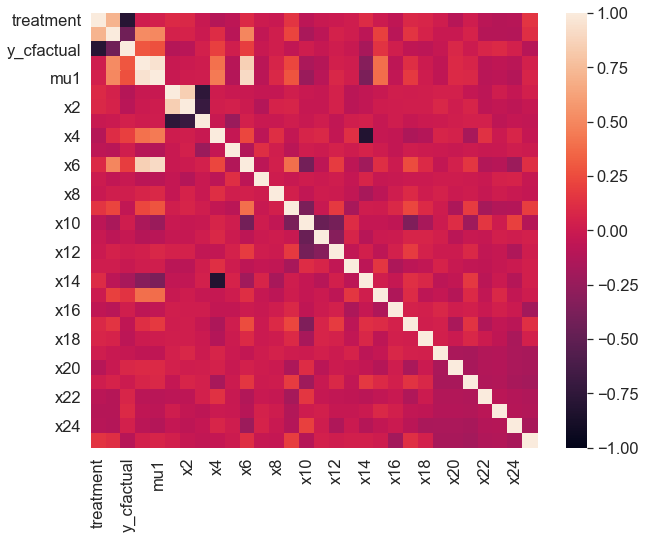

In [9]:
sns.heatmap(data.corr(), vmin=-1, vmax=1);

In [10]:
#passage en array
W=data['treatment'].values
Y=data['y_factual'].values
features=['x1', 'x2', 'x3','x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14',
       'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24',
       'x25']
X=data[features].values

## SMD Analysis

In [11]:
#passage en array
Wdf=data['treatment']
Wdf.name='W'
Ydf=data['y_factual']
Ydf.name='Y'
Xdf=data[features]

In [12]:
def create_table_one_df(dataframe=Xdf,W=Wdf,round_digits=4):
    mean_pos=Xdf[W==1].mean(axis=0)
    table_one=pd.DataFrame({'Mean Treatment':mean_pos})

    std_pos=Xdf[W==1].std(axis=0)
    table_one=table_one.join(pd.DataFrame({'Std Treatment':std_pos}),on=None)

    mean_neg=Xdf[W==0].mean(axis=0)
    table_one=table_one.join(pd.DataFrame({'Mean Control':mean_neg}),on=None)

    std_neg=Xdf[W==0].std(axis=0)
    table_one=table_one.join(pd.DataFrame({'Std Control':std_neg}),on=None)

    SMD=np.round(abs((mean_pos - mean_neg) / np.sqrt((std_pos ** 2 + std_neg ** 2) / 2)),round_digits)
    table_one=table_one.join(pd.DataFrame({'SMD':SMD}),on=None)
    return table_one

In [13]:
table_one=create_table_one_df(dataframe=Xdf,W=Wdf,round_digits=4)
table_one.loc[table_one['SMD']>=0.1]

,Mean Treatment,Std Treatment,Mean Control,Std Control,SMD
x1,0.210078,0.921394,-0.048028,1.011715,0.2667
x2,0.182776,0.888900,-0.041786,1.019784,0.2348
x4,-0.220360,0.905225,0.050378,1.014415,0.2816
x5,-0.142095,1.038872,0.032485,0.988913,0.1721
x6,0.212161,0.929679,-0.048504,1.009868,0.2686
x9,0.676259,0.469595,0.485197,0.500192,0.3938
x10,0.287770,0.454361,0.381579,0.486174,0.1994
x14,1.575540,0.496048,1.437500,0.496487,0.2782
x16,0.935252,0.246971,0.965461,0.182761,0.1390
x17,0.690647,0.463898,0.572368,0.495142,0.2465


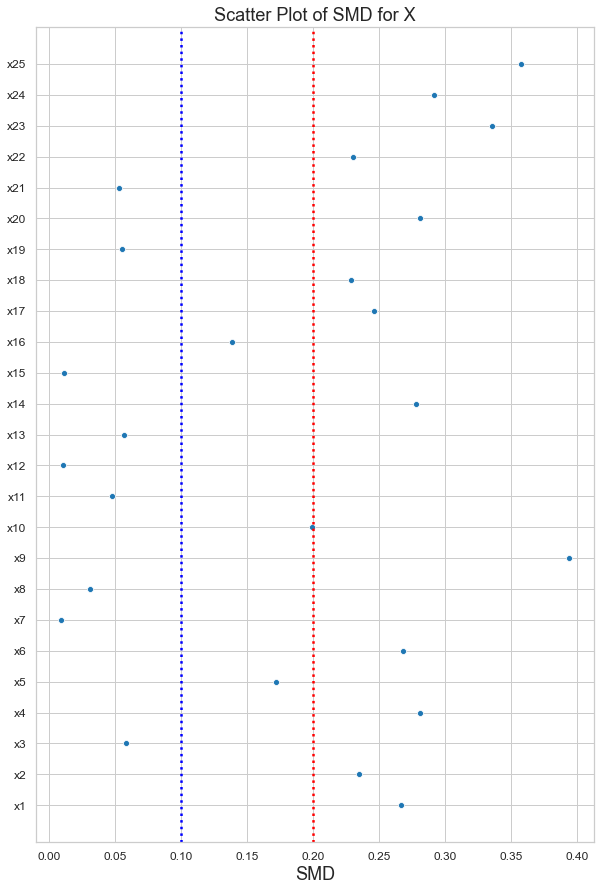

In [14]:
fig = plt.figure(figsize=(10, 15))
sns.scatterplot(table_one['SMD'],table_one.index)
plt.axvline(0.1, 0,1,ls=':',c='b')
plt.axvline(0.2, 0,1,ls=':',c='r')
plt.title("Scatter Plot of SMD for X", fontsize = 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

## Calculate propensty score

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [16]:
# classifier to estimate the propensity score
cls = LogisticRegression()
#cls = GaussianNB()  # another possible propensity score estimator

pipe=Pipeline([('scaler', StandardScaler()), ('cls', LogisticRegression())])

lr=GridSearchCV(
    estimator=pipe,
    param_grid={"cls__penalty": ('l1', 'l2', 'elasticnet'), "cls__solver": ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')},
    cv=5,
    n_jobs=-1,
)

X = Xdf.to_numpy()
w = Wdf.values
lr.fit(X, w)

# calibration of the classifier
print(lr.best_params_)
cls = CalibratedClassifierCV(lr.best_estimator_)
cls.fit(X, w)
cls.score(X, w)

{'cls__penalty': 'l1', 'cls__solver': 'liblinear'}


0.8139223560910308

In [17]:
propensity = pd.DataFrame(cls.predict_proba(X))
propensity.head()

,0,1
0,0.832602,0.167398
1,0.791987,0.208013
2,0.807562,0.192438
3,0.799124,0.200876
4,0.798623,0.201377


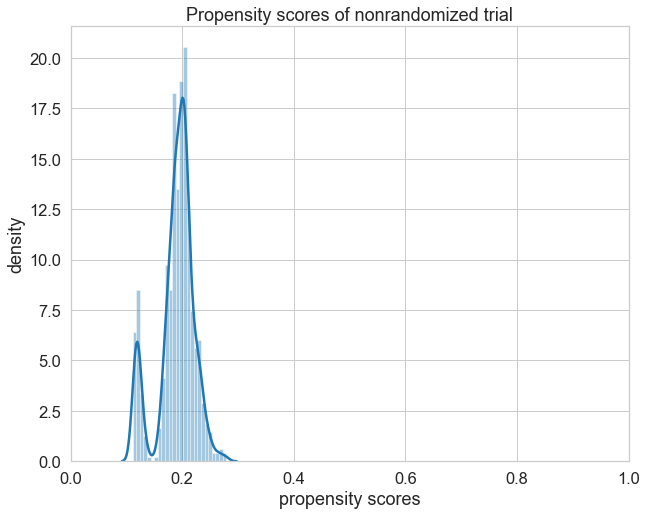

In [18]:
ax = sns.distplot(propensity[1].values)
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of nonrandomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

In [19]:
# classifier to estimate the propensity score

pipe=Pipeline([('scaler', StandardScaler()), ('cls', GaussianNB())])


X = Xdf.to_numpy()
w= Wdf.values
lr.fit(X, w)

# calibration of the classifier
print(lr.best_params_)
cls = CalibratedClassifierCV(lr.best_estimator_)
cls.fit(X, w)
cls.score(X, w)

{'cls__penalty': 'l1', 'cls__solver': 'liblinear'}


0.8139223560910308

# S-Learners

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator=LinearRegression()):
        # init
        self.estimator = base_estimator
        
    def fit(self, X, W, Y):
        # Initiation des variables
        self.X=X
        self.W=W
        self.Y=Y
        self.features = np.hstack((self.X,self.W[:,np.newaxis]))
        self.clf=self.estimator.fit(self.features,self.Y)

    def predict_CATE(self):
      #ajouter un x en parametre pour calculer le cate sur un point
        # Complete the method         
        self.Y_0_hat=self.clf.predict(np.hstack((self.X,np.zeros(len(self.W))[:,np.newaxis])))
        self.Y_1_hat=self.clf.predict(np.hstack((self.X,np.ones(len(self.W))[:,np.newaxis])))
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

In [21]:
slearner=SLearner(base_estimator=LinearRegression())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE()
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (747,).
- L'estimation de la valeur de l'ATE = 3.9286717508727107.


# T-Learners

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X=X
        self.W=W
        self.Y=Y
        self.mu_0=self.estimator0.fit(X[self.W==0,:],self.Y[self.W==0])
        self.mu_1=self.estimator1.fit(X[self.W==1,:],self.Y[self.W==1])

    def predict_CATE(self):
      #ajouter un x en parametre pour calculer le cate sur un point
        # Complete the method         
        self.Y_0_hat=self.mu_0.predict(self.X)
        self.Y_1_hat=self.mu_1.predict(self.X)
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

In [23]:
slearner=SLearner(base_estimator=LinearRegression())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE()
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (747,).
- L'estimation de la valeur de l'ATE = 3.9286717508727107.


### Prédictions des métalearners "Causal ML"


#### SLearners

In [24]:
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor


lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (Linear Regression): 3.93 (3.70, 4.16)


#### TLearners

In [25]:
from causalml.inference.meta import XGBTRegressor

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (XGBoost): 3.91 (3.81, 4.02)


#### Calcul de l'ATE

In [26]:
def ATE_paradis(beta, bias, f=lambda i:i, g=lambda i:i):
  p=beta.shape[1]
  if p==1:
    ate = integrate.quad(lambda x: (g(beta[1]*x + bias[1]) -f(beta[0]*x + bias[0]))*sp.stats.norm.pdf(x,0,1),-1000 , 1000)
  if p==2:
    ate=integrate.dblquad(lambda x, y: (g(beta[1,0]*x + beta[1,1]*y + bias[1]) -f(beta[0,0]*x + beta[0,1]*y + bias[0])
    )*sp.stats.norm.pdf(x,0,1)*sp.stats.norm.pdf(y,0,1),-1000 , 1000, lambda y :-1000,lambda y : 1000)
  if p>2:
    raise Warning('dimension above 2')
  return  ate

In [27]:
col=['x1','x5']
Xdf=Xdf[col]
X = Xdf.to_numpy()

In [28]:
X.shape

(747, 2)

In [29]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 746
d = 2                                     # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.5
beta = np.random.uniform(1, 30, (1, d))
beta = np.vstack((beta,beta))               # beta0 = beta1           
bias = np.array([10,0])                   # Gamma0 = Gamma1 
f = lambda x:x
g = lambda x:np.cos(x)

In [30]:
print('ATE: {}'.format(ATE_paradis(beta, bias, f=f, g=g)))


ATE: (-10.000000011802683, 7.612938522548885e-08)
